# Trajectory Optimization for a planar walker

## Start meshcat visualizer

Open the visualizer by clicking on the url in the output of this cell.

In [14]:
from pydrake.all import FindResourceOrThrow, StartMeshcat, MeshcatVisualizer
import matplotlib.pyplot as plt
import numpy as np
import time
from pydrake.math import RigidTransform
from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource
)
import importlib
import find_throwing_trajectory
importlib.reload(find_throwing_trajectory)
from find_throwing_trajectory import find_throwing_trajectory

meshcat = StartMeshcat()


INFO:drake:Meshcat listening for connections at http://localhost:7005


## Run trajectory optimization to find the optimal trajectory

In [15]:
N = 5
initial_state = np.zeros(14)
# final_configuration = np.array([np.pi, 0])
tf = 3.0
distance = 15.0
x_traj, u_traj, prog, _, _ = find_throwing_trajectory(N, initial_state, jumpheight = 1.5, tf=3, jumpheight_tol=5e-2)

TypeError: AddBoundingBoxConstraint(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.solvers.MathematicalProgram, arg0: numpy.ndarray[numpy.float64[m, n], flags.f_contiguous], arg1: numpy.ndarray[numpy.float64[m, n], flags.f_contiguous], arg2: numpy.ndarray[object[m, n], flags.f_contiguous]) -> pydrake.solvers.Binding𝓣BoundingBoxConstraint𝓤
    2. (self: pydrake.solvers.MathematicalProgram, arg0: float, arg1: float, arg2: pydrake.symbolic.Variable) -> pydrake.solvers.Binding𝓣BoundingBoxConstraint𝓤
    3. (self: pydrake.solvers.MathematicalProgram, arg0: float, arg1: float, arg2: numpy.ndarray[object[m, n], flags.f_contiguous]) -> pydrake.solvers.Binding𝓣BoundingBoxConstraint𝓤

Invoked with: <pydrake.solvers.MathematicalProgram object at 0x7f5047e8a6f0>, <Expression "(-0.10000000000000001 + x_0(0))">, <Expression "(0.01 + x_0(0))">, Variable('x_4(0)', Continuous)

## Visualize the optimal trajectory

This will animate the optimal trajectory in the meshcat window (see above)

In [3]:
dir(x_traj)

['AppendCubicHermiteSegment',
 'AppendFirstOrderSegment',
 'Block',
 'Clone',
 'ConcatenateInTime',
 'CubicHermite',
 'CubicShapePreserving',
 'CubicWithContinuousSecondDerivatives',
 'EvalDerivative',
 'FirstOrderHold',
 'LagrangeInterpolatingPolynomial',
 'MakeDerivative',
 'RemoveFinalSegment',
 'Reshape',
 'ReverseTime',
 'ScaleTime',
 'Transpose',
 'ZeroOrderHold',
 '__add__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__fields__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_breaks',
 '_polynomials',
 '_pybind11_del_orig',
 'cols',
 'derivative',
 'duration',
 'end_time',
 'getPolynomial',
 'getPolynomialMatrix',
 'getSegmentPolynomialDegree',
 'get_number_of_segments'

In [4]:
total_duration = 0

for i in range(4):
    total_duration += x_traj.duration(i)
total_duration

3.0

In [5]:
x_traj.vector_values(0.75)

TypeError: vector_values(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.trajectories.Trajectory, t: List[float]) -> numpy.ndarray[numpy.float64[m, n]]

Invoked with: <pydrake.trajectories.PiecewisePolynomial object at 0x7f5047ea3b30>, 0.75

7 7 4


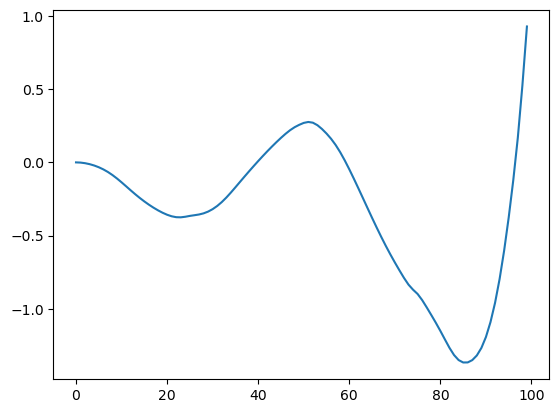

In [13]:
# Create a MultibodyPlant for the arm
file_name = "planar_walker.urdf"
builder = DiagramBuilder()
scene_graph = builder.AddSystem(SceneGraph())
robot = builder.AddSystem(MultibodyPlant(0.0))
robot.RegisterAsSourceForSceneGraph(scene_graph)
Parser(plant=robot).AddModels(file_name)
robot.WeldFrames(
            robot.world_frame(),
            robot.GetBodyByName("base").body_frame(),
            RigidTransform.Identity()
)
robot.Finalize()

n_q = robot.num_positions()
n_v = robot.num_velocities()
n_u = robot.num_actuators()
print(n_q, n_v, n_u)

# x_traj_mod = np.zeros((n))
x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(robot))
zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_u)))

builder.Connect(zero_inputs.get_output_port(), robot.get_actuation_input_port())
builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(robot.get_source_id()))

MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
diagram.set_name("diagram")
context = diagram.CreateDefaultContext()
simulator = Simulator(diagram)
simulator.Initialize()
simulator.set_target_realtime_rate(1)
robot_context = diagram.GetMutableSubsystemContext(robot, simulator.get_mutable_context())

timesteps = np.linspace(0, 3.0, 100)
com_pos_list = []
for t in timesteps:
  x = x_traj.vector_values([t])
  robot.SetPositionsAndVelocities(robot_context, x)
  com_pos = robot.CalcCenterOfMassPositionInWorld(robot_context).ravel()
  com_pos_list.append(com_pos[0])
  # simulator.AdvanceTo(t)
  # time.sleep(2)

# # Visualize the motion for `n_playback` times
# n_playback = 3
# for i in range(n_playback):
#   # Set up a simulator to run this diagram.
#   simulator = Simulator(diagram)
#   simulator.Initialize()
#   simulator.set_target_realtime_rate(1)
#   simulator.AdvanceTo(tf);
#   time.sleep(2)

fig = plt.figure()
plt.plot(timesteps, com_pos_list)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=71c969e2-d88b-4bfd-96cb-c4ea4f7f9122' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>